In [122]:
import subprocess
import os
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax
# from snsynth.gsd import GSDSynthesizer
from snsynth.gsd.utils.dataset_jax import Dataset, Domain
from snsynth.gsd.utils.statistics import _get_mixed_marginal_fn, _get_bin_edges, get_quantiles
from snsynth.utils import cdp_rho
import matplotlib.pyplot as plt
from snsynth.gsd.utils.statistics import _get_mixed_marginal_fn, _get_bin_edges, _get_density_fn, get_quantiles

from snsynth.gsd.utils.utils import get_sigma, _divide_privacy_budget
from snsynth.utils import gaussian_noise
from scipy.optimize import minimize, rosen, rosen_der

In [105]:
def psi(x):
    # print(x)
    temp = np.where(x>= 0, np.log(1+x+x**2/2), -np.log(1-x+x**2/2))
    # print(temp)
    return temp

    

def robust_mean_est(values, variances, data_range, mean_candidates=None):
    if mean_candidates is None:
        mean_candidates = np.linspace(0, data_range, 100001)
    n = len(values)
    def r(theta):
        r_val=0
        for x, var in zip(values, variances):
            alpha = np.sqrt(2  / (n * var))
            r_val += psi(alpha * (x - theta))
        return r_val
    R = r(mean_candidates)
    # print('R=', R)
    best_mean = np.argmin(np.abs(R))
    return mean_candidates[best_mean]


def weighted_est(values, variaces):
    values = np.array(values)
    vars = np.array(variances)
    weights = vars / vars.sum()

    mean = np.dot(values, weights)
    return mean



print(robust_mean_est([0.4, 0.36, 0.4, 0.37, 0.41, 0.42], [1, 1, 1, 1, 1, 1], 1))

0.39333


In [ ]:
# errors_trivial = []
# errors_weighted = []
# errors_catoni = []
# errors_first_mean = []



data_range = 0.1
M = 0.02

np.random.seed(0)
sigmas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for init_sigma in sigmas:
    tries = 1000
    mean_trivial = np.zeros(tries)
    mean_trivial_clip = np.zeros(tries)
    mean_first_mean = np.zeros(tries)
    mean_first_mean_clip =np.zeros(tries)
    mean_catoni = np.zeros(tries)
    mean_catoni_clip = np.zeros(tries)
    errors = {}
    
    for i in range(1000):
        T = 14
        values = np.array([M + np.sqrt(init_sigma * (2** t)) * np.random.randn() for t in range(1, T)])
        values_clip = np.clip(values, 0, data_range)
        variances = np.array([np.sqrt(init_sigma * (2** t))  for t in range(1, T)])
        
        # print(f'secret_mean={secret_mean}, empirical mean={np.mean(values)}')

        mean_trivial[i] =  np.mean(values)
        mean_trivial_clip[i] = np.mean(values_clip)
        mean_first_mean[i] = values[0]
        mean_first_mean_clip[i] = values_clip[0]
        mean_catoni[i] = robust_mean_est(values, variances, data_range)
        mean_catoni_clip[i] = robust_mean_est(values_clip, variances, data_range)


    def print_bias_var(means):
        print(f'\tbias={np.clip(np.mean(means), 0, data_range) - M:<2.6f}, variance={np.abs(np.clip(means,0, data_range)-M).mean():.6f}')


    print(f'\ninit_sigma={init_sigma:.5f}')

    print(f'Trivial')
    print_bias_var(mean_trivial)
    print(f'Trivial(clip)')
    print_bias_var(mean_trivial_clip)

    print(f'first mean')
    print_bias_var(mean_first_mean)
    
    print(f'first mean(clip)')
    print_bias_var(mean_first_mean_clip)

    print(f'Catoni')
    print_bias_var(mean_catoni)
    
    print(f'Catoni(clip)')
    print_bias_var(mean_catoni_clip)
    

    # print(f'first            : bias={np.mean(mean_first_mean) - M:<2.4f}, variance={np.abs(mean_first_mean-M).mean():.4f}')
    # print(f'first(clip)      : bias={np.mean(mean_first_mean_clip) - M:<2.4f}, variance={np.abs(mean_first_mean_clip-M).mean():.4f}')

    # print(f'catoni           : bias={np.mean(mean_catoni) - M:<2.4f}, variance={np.abs(mean_catoni-M).mean()}:.4f')
    # print(f'catoni(clip)     : bias={np.mean(mean_catoni_clip) - M:<2.4f}, variance={np.abs(mean_catoni_clip-M).mean():.4f}')

    
    # print(f'error(trival_mean_est)  = {np.mean(errors_trivial):.4f} ({np.std(errors_trivial):.4f})')
    # print(f'error(first mean)       = {np.mean(errors_first_mean):.4f} ({np.std(errors_first_mean):.4f})')
    # print(f'error(catoni)           = {np.mean(errors_catoni):.4f} ({np.std(errors_catoni):.4f})')
    # print()

0.6972090589610946

In [131]:



    
def naive_density(values, data_range, eps):
    N = values.shape[0]
    rho = cdp_rho(eps, 1e-9)
    sigma = get_sigma(rho, sensitivity=np.sqrt(2) / N)

    num_bins = 10000
    bin_edges = np.linspace(0, data_range, num_bins)

    T = bin_edges[:-1]
    
    hist = np.histogram(values, bins=bin_edges)[0] / N
    density = hist.cumsum()

    noisy_hist = hist + gaussian_noise(sigma=sigma, size=hist.shape[0])  # Add DP
    noisy_density = noisy_hist.cumsum()

    ## Plot histogram
    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(10)
    axs[0].bar(T, hist, width=data_range/100)
    axs[1].bar(T, noisy_hist, width=data_range/100)
    # axs[2].bar(T, noisy_density_post, width=data_range/100)
    # plt.yticks([])
    plt.show()

    plt.plot(T, density, label='True Density')
    plt.plot(T, noisy_density, label='Noisy')
    # plt.plot(T, noisy_density_post, label='Post-Noisy')

    plt.legend()
    plt.show()




np.random.seed(0)
data_range = 1
meta_data = {'O1': {'type': 'float', 'size': data_range}}
values = np.concatenate((
    # 10 * np.ones(5000).astype(int),
                         np.random.randint(1, 2, size=(6000,)),
                         # np.random.randint(1000, 2000, size=(200,)),
                         np.random.randint(500, 510, size=(2000,)),
                         np.random.randint(8500, 9500, size=(2000,))
                         ))


values = np.clip(np.concatenate((
    # 10 * np.ones(5000).astype(int),
                         0.001 * np.random.randn(6000) + 0.01,
                         # np.random.randint(1000, 2000, size=(200,)),
                         0.01 * np.random.randn(2000) + 0.3,
                         0.001 * np.random.randn(2000) + 0.7
                         )), 0, 1)


print(values)
df = pd.DataFrame({'O1': values})
domain = Domain(config=meta_data)
data = Dataset(df, domain)
N= len(df)


# for eps in [0.1, 1.0, 100.0]:
#     naive_density(data.df.values, data_range, eps)
    # continue


[0.0098119  0.00884579 0.01085647 ... 0.69855316 0.70008102 0.6999226 ]


In [98]:

def post_histogram_tree(hist_tree: dict, clip=False):
    # normalize_hist_tree = {}

    H = hist_tree['tree_height']

    # First level must add up to 1
    hist0 = np.array(hist_tree['stats'][0])
    if clip:
        hist0 = np.clip(hist0, 0, 1)
    hist0 = hist0 / hist0.sum()
    hist_tree['stats'][0] = hist0

    for h in range(1, H):
        reg_hist = np.array(hist_tree['stats'][h])
        # normalized_hist = np.clip(np.array(hist_tree['stats'][h]), 0, 1)
        normalized_hist = np.array(hist_tree['stats'][h])
        hist_len = normalized_hist.shape[0]

        for i in range(0, hist_len, 2):
            parent_i = i // 2
            parent_stat = hist_tree['stats'][h-1][parent_i]

            
            
            if clip:
                assert parent_stat>=0
            child_hist = normalized_hist[i:i+2]
            if clip:
                child_hist = np.clip(child_hist, 0, parent_stat)
            if child_hist.sum() < 1e-9:
                normalized_hist[i:i+2] = parent_stat * np.ones(2) / 2
            else:
                child_hist = parent_stat * child_hist / child_hist.sum()
                normalized_hist[i:i+2] = child_hist

        print(f'h={h}. hist.sum={normalized_hist.sum():.2f}\treg_hist = {reg_hist.sum():.2f}')
        hist_tree['stats'][h] = list(normalized_hist)

    return hist_tree



def post_histogram_tree2(hist_tree_arg: dict, sigma: float, clip=False):
    # normalize_hist_tree = {}
    H = hist_tree_arg['tree_height']

    hist_tree = [np.array([1])]
    for h in range(0, H):
        hist_tree.append(np.array(hist_tree_arg['stats'][h]))

        
    for h in range(1, H):
        reg_hist = np.array(hist_tree[h])
        # normalized_hist = np.clip(np.array(hist_tree['stats'][h]), 0, 1)
        normalized_hist = np.array(hist_tree[h])
        hist_len = normalized_hist.shape[0]
        # print(f'hist_tree[{h}]=',hist_tree[h])
        # print(f'h={h}')
        # Update stimate of each root at level h
        for i in range(0, hist_len):
            parent_stat = hist_tree[h-1][i//2] 
            # sum = hist_tree[h][i]
            if h <= 3:
                print(f'\troot_org[h={h}, i={i}] = {hist_tree[h][i]:.4f}, parent_stat={parent_stat:.4f}')

            estimates = [np.clip(hist_tree[h][i], 0, parent_stat)]
            variances = [sigma]
            for j, h2 in enumerate(range(h+1, H)):
                lo = 2**(j+1) * i
                hi = 2**(j+1) * i + 2**(j+1)
                estimate = hist_tree[h2][lo:hi].sum()
                estimate_clip = np.clip(estimate, 0, parent_stat)
                # print(f'\t\testimate[h={h2}, {lo}:{hi}] = {estimate:.4f}')
                # sum += estimate_clip
                estimates.append(estimate_clip)
                variances.append((sigma**2) * (2**(j+1)))
            root_avg = np.mean(estimates)
            cat_avg = robust_mean_est(estimates, variances, parent_stat)
            if h <= 3:
                print(f'\t\troot_avg[h={h}, i={i}] = {root_avg:.4f}, cat_avg={cat_avg:.4f}, parent_stat={parent_stat:.4f}')
            hist_tree[h][i] = estimates[0]

        
        # print(f'\n')
        for i in range(0, hist_len, 2):
            parent_i = i // 2
            parent_stat = hist_tree[h-1][parent_i]
            
            if clip:
                assert parent_stat>=0
            child_hist = normalized_hist[i:i+2]
            if clip: child_hist = np.clip(child_hist, 0, parent_stat)
            if child_hist.sum() < 1e-9: normalized_hist[i:i+2] = parent_stat * np.ones(2) / 2
            else:
                child_hist = parent_stat * child_hist / child_hist.sum()
                normalized_hist[i:i+2] = child_hist

        print(f'h={h}. hist.sum={normalized_hist.sum():.2f}\treg_hist = {reg_hist.sum():.2f}, min={normalized_hist.min()}')
        hist_tree[h] = list(normalized_hist)

        hist_tree_arg['stats'][h-1] = list(hist_tree[h])

    return hist_tree_arg

tree_height = 10
bin_edges = _get_bin_edges(domain=data.domain, tree_height=tree_height)
_, _, marginals_info = _get_mixed_marginal_fn(data, k=1, bin_edges=bin_edges, rho=None,
                                              store_marginal_stats=True,
                                              verbose=True)

# sigma = get_sigma(rho/tree_height, sensitivity=np.sqrt(2) / N)
# print(f'Debug: sigma={sigma}.')
# post_histogram_tree2(marginals_info[('O1',)], sigma)


_, _, threshold, density = get_quantiles(marginals_info[('O1',)], num_quantiles=100)

Cond.Marginal= ['O1'] . Sigma=0.0000. Top.Level=10. Max.Size=None
	Total size=2046


In [ ]:

def get_stat(data_arg, tree_height_arg, rho_1):
    dim = len(data_arg.domain.attrs)
    numeric_features = data_arg.domain.get_numeric_features()
    bin_edges = _get_bin_edges(domain=data_arg.domain, tree_height=tree_height_arg)

    _, _, marginals_info = _get_mixed_marginal_fn(data_arg, k=1, bin_edges=bin_edges, rho=rho_1,
                                                           store_marginal_stats=True,
                                                                           features=numeric_features,
                                                               verbose=True)

    # Compute density function
    density_fn_params = []
    priv_density = []
    for col in numeric_features:
        thres_q, den_q, thres_all, density_all = get_quantiles(marginals_info[(col,)], 200)
        # Save threshold for computing the density function
        col_id = data.domain.get_attribute_index(col)
        for q, d in zip(thres_q, den_q):
            density_fn_params.append([col_id, q])
            priv_density.append(d)
    
        # Store column histogram bin edges
        numeric_features_bin_edges[col] = jnp.array(thres_q)
    
    
    # Obtain first moment statistics and function.
    priv_density_np = jnp.array(priv_density)
    density_fn = _get_density_fn(jnp.array(density_fn_params))
    
    # Special case: 1-dimensional numeric dataset
    if dim == 1:
        return priv_density_np, density_fn, numeric_features_bin_edges


    priv_stats_2k, stat_fn_2k = _get_mixed_marginal_fn(data_arg, k=2, 
                                                       bin_edges=bin_edges, 
                                                       rho=rho_2,
                                                       verbose=True)

    # Combine first and second moment statistics
    def stat_fn_all(X):
        stat_1k = density_fn(X)
        stat_2k = stat_fn_2k(X)
        return jnp.concatenate((stat_1k, stat_2k))

    # General case: d-dimensional mixed-type dataset:
    priv_stats_all = jnp.concatenate((jnp.array(priv_density_np), jnp.array(priv_stats_2k)))
    return priv_stats_all, stat_fn_all, numeric_features_bin_edges

sigma = 0.03360
Cond.Marginal= ['O1'] . Sigma=0.0336. Top.Level=10. Max.Size=None
	Total size=2046
h=1. hist.sum=1.00	reg_hist = 0.97
h=2. hist.sum=1.00	reg_hist = 0.89
h=3. hist.sum=1.00	reg_hist = 0.98
h=4. hist.sum=1.00	reg_hist = 0.90
h=5. hist.sum=1.00	reg_hist = 1.50
h=6. hist.sum=1.00	reg_hist = 1.11
h=7. hist.sum=1.00	reg_hist = 0.28
h=8. hist.sum=1.00	reg_hist = 0.77
h=9. hist.sum=1.00	reg_hist = 1.68
error1 = 19.50618
error3 = 0.59618
error = 0.5961797090353367


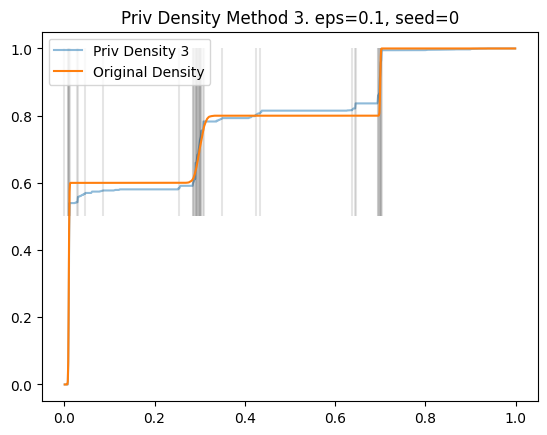

sigma = 0.03360
Cond.Marginal= ['O1'] . Sigma=0.0336. Top.Level=10. Max.Size=None
	Total size=2046
h=1. hist.sum=1.00	reg_hist = 1.11
h=2. hist.sum=1.00	reg_hist = 1.02
h=3. hist.sum=1.00	reg_hist = 0.87
h=4. hist.sum=1.00	reg_hist = 0.80
h=5. hist.sum=1.00	reg_hist = 1.47
h=6. hist.sum=1.00	reg_hist = 1.44
h=7. hist.sum=1.00	reg_hist = 0.56
h=8. hist.sum=1.00	reg_hist = 2.29
h=9. hist.sum=1.00	reg_hist = 1.51
error1 = 19.50618
error3 = 1.59757
error = 1.5975727512869051


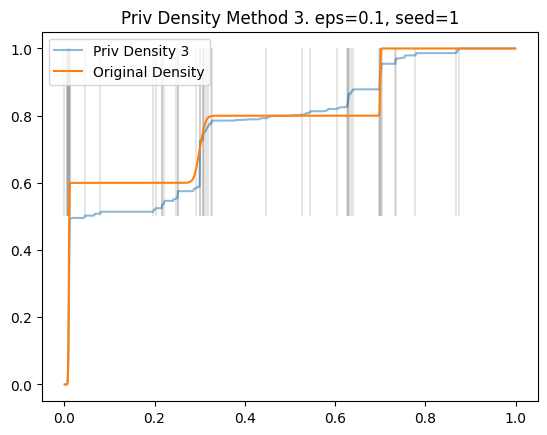

sigma = 0.03360
Cond.Marginal= ['O1'] . Sigma=0.0336. Top.Level=10. Max.Size=None
	Total size=2046
h=1. hist.sum=1.00	reg_hist = 1.14
h=2. hist.sum=1.00	reg_hist = 0.90
h=3. hist.sum=1.00	reg_hist = 1.00
h=4. hist.sum=1.00	reg_hist = 1.06
h=5. hist.sum=1.00	reg_hist = 0.74
h=6. hist.sum=1.00	reg_hist = 0.46
h=7. hist.sum=1.00	reg_hist = 1.10
h=8. hist.sum=1.00	reg_hist = 1.26
h=9. hist.sum=1.00	reg_hist = -0.85
error1 = 19.50618
error3 = 1.32198
error = 1.3219764772008862


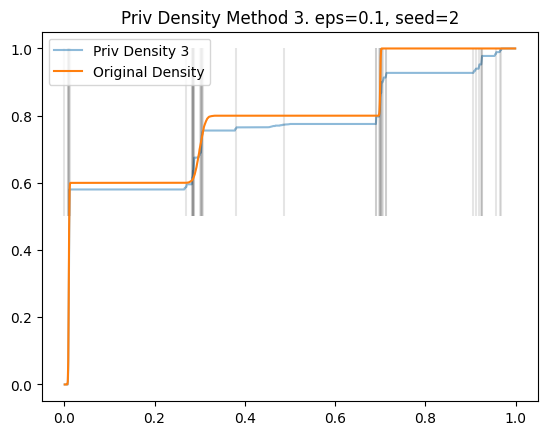

In [139]:
Densities = {}
for eps in [0.1]:
    Densities[eps] = {}
    for seed in [0, 1, 2]:
        Densities[eps][seed] = []
        rho = cdp_rho(eps, 1e-9)
        np.random.seed(seed)
        sigma = get_sigma(rho/tree_height, sensitivity=np.sqrt(2) / N)
        print(f'sigma = {sigma:.5f}')
    
        bin_edges = _get_bin_edges(domain=data.domain, tree_height=tree_height)
        _, _, marginals_info = _get_mixed_marginal_fn(data, k=1, bin_edges=bin_edges, rho=rho,
                                                      store_marginal_stats=True,
                                                      verbose=True)
        hist_tree = marginals_info[('O1',)]
        
        # q1, _, t1, priv_density1 = get_quantiles(hist_tree, num_quantiles=100)
    
        hist_tree_normed_clipped = post_histogram_tree(hist_tree, clip=True)
        q3, _, t3, priv_density3 = get_quantiles(hist_tree_normed_clipped, num_quantiles=100)
        print(f'error1 = {np.linalg.norm(np.array(density) - np.array(priv_density1)):.5f}')
        print(f'error3 = {np.linalg.norm(np.array(density) - np.array(priv_density3)):.5f}')
        Densities[eps][seed].append((t3, priv_density3))


    
        # plt.title(f'Priv Density Method 1. eps={eps}, seed={seed}')
        # plt.plot(t1, priv_density1, label='Priv Density', alpha=0.5)
        # plt.vlines(x=q1, ymin=0.5, ymax=1, colors='k', alpha=0.1)
        # plt.plot(threshold, density, label='Original Density')
        # plt.legend()
        # plt.show()
        
        plt.title(f'Priv Density Method 3. eps={eps}, seed={seed}')
        plt.plot(t3, priv_density3, label='Priv Density 3', alpha=0.5)
        plt.vlines(x=q3, ymin=0.5, ymax=1, colors='k', alpha=0.1)
        plt.plot(threshold, density, label='Original Density')
        plt.legend()
        plt.show()

In [110]:
hist_tree_normed_clipped['stats']

{0: array([ 1.15810552, -0.15810552]),
 1: [0.6277175793391782,
  0.5303879428360138,
  -0.06487434205766328,
  -0.09323118011752865],
 2: [0.5900488474806947,
  0.03766873185848332,
  0.4890965178287099,
  0.04129142500730389,
  -0.03243717102883164,
  -0.03243717102883164,
  0.03913782215043019,
  -0.13236900226795886],
 3: [0.3728302410944393,
  0.2172186063862554,
  0.01883436592924166,
  0.01883436592924166,
  0.2620341123211778,
  0.22706240550753212,
  0.020645712503651947,
  0.020645712503651947,
  -0.01621858551441582,
  -0.01621858551441582,
  -0.0006965316447201904,
  -0.03174063938411145,
  0.04173437898255912,
  -0.0025965568321289277,
  -0.022034308437033672,
  -0.11033469383092519],
 4: [-0.14670980882743637,
  0.5195400499218756,
  0.1086093031931277,
  0.1086093031931277,
  0.00941718296462083,
  0.00941718296462083,
  0.00941718296462083,
  0.00941718296462083,
  -0.021207042263263847,
  0.28324115458444166,
  0.0958081416816073,
  0.1312542638259248,
  0.010322856251

In [ ]:
# Fit GSD here on all binary tree queries.

In [149]:
from snsynth.gsd.utils.generate_sync_data import generate, AVAILABLE_GENETIC_OPERATORS
    
def plot_density(values, sync_values, data_range):
    N = values.shape[0]
    N_sync = sync_values.shape[0]

    num_bins = 10000
    bin_edges = np.linspace(0, data_range, num_bins)
    T = bin_edges[:-1]

    hist = np.histogram(values, bins=bin_edges)[0] / N
    density = hist.cumsum()

    hist_sync = np.histogram(sync_values, bins=bin_edges)[0] / N_sync
    density_sync = hist_sync.cumsum()
    
    error = np.linalg.norm(np.array(density) - np.array(density_sync))
    error_max = np.abs(np.array(density) - np.array(density_sync)).max()

    print(f'error = {error:.5f}, error_max={error_max:.5f}')
    
    ## Plot histogram
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(10)
    axs[0].bar(T, hist, width=data_range/100)

    axs[1].bar(T, hist_sync, width=data_range/100)

    axs[2].plot(T, density, label='Real')
    axs[2].plot(T, density_sync, label='Sync')
    plt.legend()
    # plt.yticks([])
    plt.show()

In [136]:
density_fn_params = []
priv_density = []
# Save threshold for computing the density function
col_id = data.domain.get_attribute_index('O1')
for q, d in zip(t1, priv_density1):
    density_fn_params.append([col_id, q])
    priv_density.append(d)103..2
priv_density_np = jnp.array(priv_density)
density_fn = _get_density_fn(jnp.array(density_fn_params))


sync_data_1 = generate(jax.random.PRNGKey(0),
                                domain=domain,
                                N_prime=1000,
                                num_generations=50000000,
                                private_statistics=priv_density_np,
                                statistics_fn=density_fn,
                                # genetic_operators=genetic_operators,
                                # early_stop_threshold=early_stop_threshold,
                                print_progress=True)

Gen=      1000: fitness=377.021888. fitness change=0.99999962  Strategy weights:  [1.] time=1.57 (s)
Gen=      2000: fitness=371.692993. fitness change=0.01413418  Strategy weights:  [1.] time=2.69 (s)
Gen=      3000: fitness=370.910215. fitness change=0.00210598  Strategy weights:  [1.] time=3.74 (s)
Gen=      4000: fitness=370.738707. fitness change=0.00046240  Strategy weights:  [1.] time=4.81 (s)
Gen=      5000: fitness=370.676965. fitness change=0.00016654  Strategy weights:  [1.] time=5.88 (s)
Gen=      6000: fitness=370.658191. fitness change=0.00005065  Strategy weights:  [1.] time=6.93 (s)
		 ### Stop early at 6000 ###


error = 7.52954, error_max=0.24060


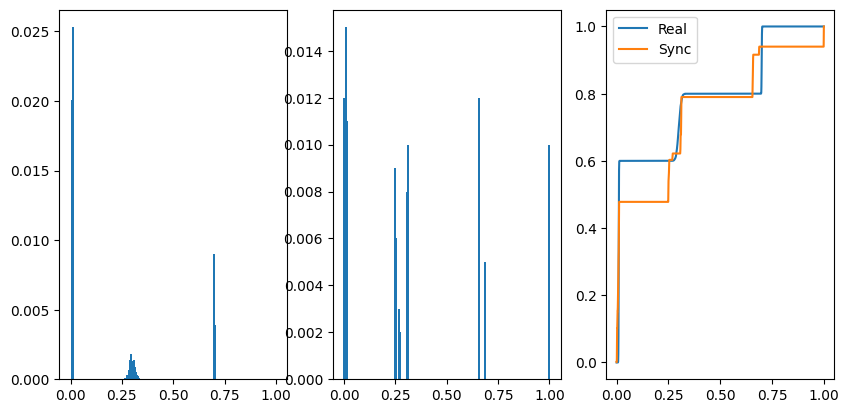

In [150]:
plot_density(values, sync_data_1.df.values.squeeze(), 1)

In [146]:
density_fn_params = []
priv_density = []

# thres_q, den_q, thres_all, density_all = get_quantiles(marginals_info[(col,)], 200)

# Save threshold for computing the density function
col_id = data.domain.get_attribute_index('O1')
for q, d in zip(t1, priv_density3):
    density_fn_params.append([col_id, q])
    priv_density.append(d)
priv_density_np = jnp.array(priv_density)
density_fn = _get_density_fn(jnp.array(density_fn_params))

In [147]:


sync_data_2 = generate(jax.random.PRNGKey(0),
                                domain=domain,
                                N_prime=1000,
                                num_generations=50000000,
                                private_statistics=priv_density_np,
                                statistics_fn=density_fn,
                                # genetic_operators=genetic_operators,
                                # early_stop_threshold=early_stop_threshold,
                                print_progress=True)

Gen=      1000: fitness=1.03503322. fitness change=1.00000000  Strategy weights:  [1.] time=1.53 (s)
Gen=      2000: fitness=0.197918708. fitness change=0.80878033  Strategy weights:  [1.] time=2.61 (s)
Gen=      3000: fitness=0.0802113759. fitness change=0.59472565  Strategy weights:  [1.] time=3.56 (s)
Gen=      4000: fitness=0.0320338839. fitness change=0.60063166  Strategy weights:  [1.] time=4.51 (s)
Gen=      5000: fitness=0.0162146195. fitness change=0.49382911  Strategy weights:  [1.] time=5.47 (s)
Gen=      6000: fitness=0.0092605368. fitness change=0.42887733  Strategy weights:  [1.] time=6.42 (s)
Gen=      7000: fitness=0.00521457572. fitness change=0.43690351  Strategy weights:  [1.] time=7.37 (s)
Gen=      8000: fitness=0.00266967661. fitness change=0.48803570  Strategy weights:  [1.] time=8.32 (s)
Gen=      9000: fitness=0.00144242073. fitness change=0.45970208  Strategy weights:  [1.] time=9.29 (s)
Gen=     10000: fitness=0.000912529142. fitness change=0.36736271  Strate

error = 4.14863, error_max=0.12860


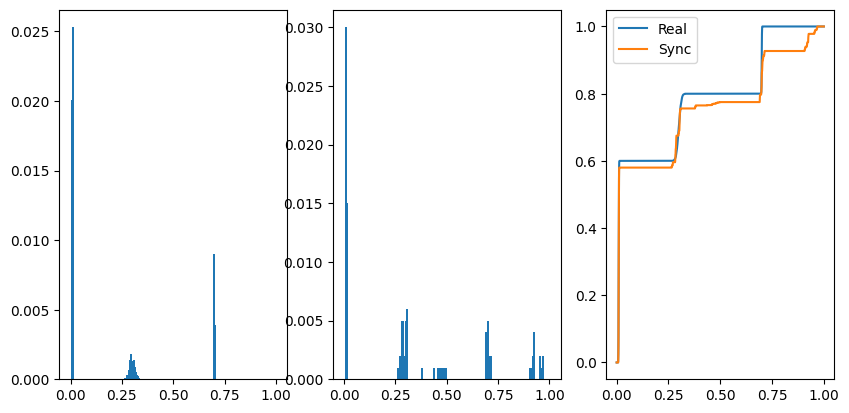

In [151]:


    # plt.plot(T, density, label='True Density')
    # # plt.plot(T, noisy_density_post, label='Post-Noisy')

    # plt.legend()
    # plt.show()

plot_density(values, sync_data_2.df.values.squeeze(), 1)